In [2]:
import matplotlib as plt
import pandas as pd
import eurostat
import pycountry
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter


In [3]:
man_data = eurostat.get_data_df('nama_10_a64')
#print(data['nace_r2'].unique())

In [4]:
gdp_data = eurostat.get_data_df('nama_10_gdp')

In [5]:
# Load the lfsq_egana2d dataset
emp_data = eurostat.get_data_df('lfsq_egan22d')
#extract the data for C29: Manufacture of motor vehicles, trailers and semi-trailers

# Prepare the Manufacturing Data from Eurostat

In [6]:
manufacturing_data = man_data[man_data['nace_r2'] == 'C29'] #Extract car Manufacturing
nominal_manufacturing_data = manufacturing_data[manufacturing_data['unit'] == 'CP_MEUR'] #Nominal Euro Prices
nominal_manufacturing_data = nominal_manufacturing_data[nominal_manufacturing_data['na_item'] == 'B1G'] #Gross Value Added

nominal_manufacturing_data.drop(columns=['freq', 'nace_r2', 'unit', 'na_item'], inplace=True)

nominal_manufacturing_data_2019 = nominal_manufacturing_data[['geo\TIME_PERIOD', '2019']]

nominal_manufacturing_data_2019.rename(columns={'geo\\TIME_PERIOD': 'country'}, inplace=True)

nominal_manufacturing_data_2019.set_index('country', inplace=True)
nominal_manufacturing_data_2019.columns = ['Gross Value Added (2019)']

C:\Users\jonas\AppData\Local\Temp\ipykernel_1792\3133223994.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominal_manufacturing_data_2019.rename(columns={'geo\\TIME_PERIOD': 'country'}, inplace=True)


# Prepare GDP Data From Eurostat

In [7]:
gdp_data_2019 = gdp_data[(gdp_data['unit'] == 'CP_MEUR') & (gdp_data['na_item'] == 'B1GQ')]
gdp_data_2019_clean = gdp_data_2019[['unit', 'na_item', 'geo\\TIME_PERIOD', '2019']]
gdp_data_2019_clean.rename(columns={'2019': 'nGDP_2019', 'geo\TIME_PERIOD' : 'country'}, inplace=True)
gdp_data_2019_clean.set_index('country', inplace=True) 
gdp_data_2019_clean.drop(columns=['unit', 'na_item'], inplace=True)
#gdp_data_2019_clean

C:\Users\jonas\AppData\Local\Temp\ipykernel_1792\1705567352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_2019_clean.rename(columns={'2019': 'nGDP_2019', 'geo\TIME_PERIOD' : 'country'}, inplace=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_1792\1705567352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_2019_clean.drop(columns=['unit', 'na_item'], inplace=True)


In [8]:
# Add to existing df -> here if value is missing -> NaN 
merged_data = nominal_manufacturing_data_2019.merge(gdp_data_2019_clean, left_index=True, right_index=True)
merged_data.rename(columns={'Gross Value Added (2019)': 'C29_2019'}, inplace=True)
merged_data['man_share_GDP_2019'] = merged_data['C29_2019'] / merged_data['nGDP_2019']
gdp_analysis_data = merged_data['man_share_GDP_2019']
gdp_analysis_data = pd.DataFrame(gdp_analysis_data)

In [9]:
gdp_analysis_data.reset_index(inplace=True)
gdp_analysis_data.set_index('country', inplace=True)

gdp_analysis_data = gdp_analysis_data['man_share_GDP_2019']
gdp_analysis_data = gdp_analysis_data.to_frame()
#gdp_analysis_data

### Renamimng of colums
here not used

In [10]:
# Create a mapping from country names to ISO 3 codes
#country_to_iso3 = {country.name: country.alpha_2 for country in pycountry.countries}

# Replace country names with ISO 3 codes in the 'country' column
#gdp_analysis_data.index = analysis_data.index.map(lambda x: pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else x)
#gdp_analysis_data.rename(index={'EL': 'Greece'}, inplace=True)

# Prepare Employment Data

In [11]:
# Extract car manufacturing employment data
employment_data = emp_data[emp_data['nace_r2'] == 'C29']  # Extract car manufacturing employment data
employment_data = employment_data[employment_data['unit'] == 'THS_PER']  # Employment in thousands
employment_data = employment_data[employment_data['sex'] == 'T']  # Total employment
employment_data = employment_data[employment_data['age'] == 'Y_GE15']  # Age group 15 and above

employment_data.drop(columns=['freq', 'nace_r2', 'unit', 'sex', 'age'], inplace=True)

employment_data = employment_data[['geo\\TIME_PERIOD', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4']]

#Sum up the columns and divide by 4, handling NaN values -> mean realizes when there is no data
employment_data['Average'] = employment_data[['2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4']].mean(axis=1)

# Replace NaN values with "no data"
employment_data['Average'] = employment_data['Average'].apply(lambda x: 'no data' if pd.isna(x) else x)

employment_data = employment_data[['geo\\TIME_PERIOD', 'Average']]
employment_data.columns = ['country', 'emp_2019']
employment_data.set_index('country', inplace=True)

# Merge the Eurostat analysis data

In [12]:
master = gdp_analysis_data.merge(employment_data, left_index=True, right_index=True)

### To drop colums not needed

In [13]:
eu_countries = master.index.unique()

# Create list of EU countries
eu_countries = [country for country in eu_countries if country not in ['EA12', 'EA19', 'EA20', 'EU27_2020']]

merged_employment_manufacturing = master.loc[eu_countries]
master_data_df = merged_employment_manufacturing

### Rename index to names for map analysis

In [14]:
# Create a mapping from country codes to country names
code_to_country = {country.alpha_2: country.name for country in pycountry.countries}

# Replace country codes with country names in the index
master_data_df.index = master_data_df.index.map(lambda x: code_to_country.get(x, x))
master_data_df.rename(index={'EL': 'Greece'}, inplace=True) #Greece somhow problematic??

# Display the updated DataFrame
#master_data_df

In [15]:
master_data_df.rename(index={'Türkiye': 'Turkey', 'UK' : 'United Kingdom', 'Bosnia and Herzegovina' : 'Bosnia and Herz.'}, inplace=True)
master_data_df.loc['Albania'] = [float('nan'), float('nan')]
master_data_df.loc['Kosovo'] = [float('nan'), float('nan')]
master_data_df.loc['Russia'] = [float('nan'), float('nan')]
master_data_df.loc['Ukraine'] = [float('nan'), float('nan')]
master_data_df.loc['Belarus'] = [float('nan'), float('nan')]
master_data_df.loc['Moldova'] = [float('nan'), float('nan')]

# Prepare the Map Data

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
eu_countries_gdf = world[world['name'].isin(master_data_df.index)]

merged_gdf = eu_countries_gdf.merge(master_data_df, left_on='name', right_index=True)
merged_gdf.rename(columns={'name': 'country'}, inplace=True)
merged_gdf.set_index('country', inplace=True)

C:\Users\jonas\AppData\Local\Temp\ipykernel_1792\4029643492.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


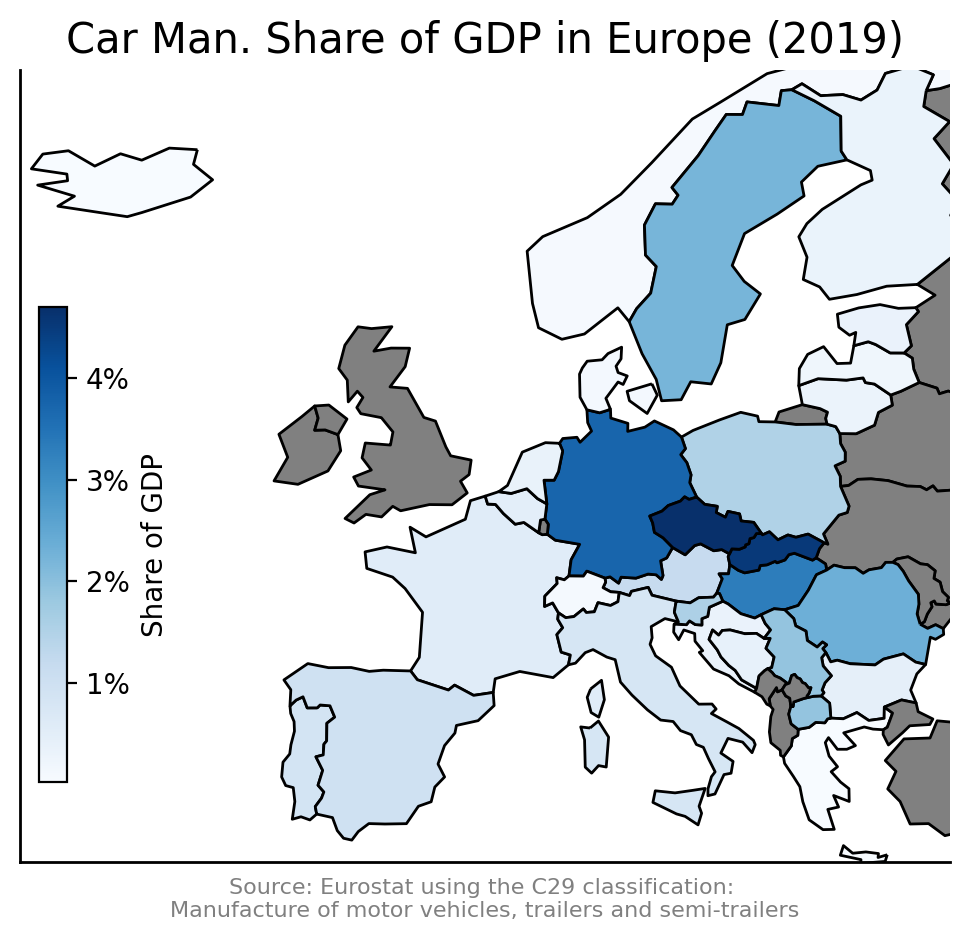

In [17]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)

# ScalarMappable -> colorbar
cmap = plt.get_cmap('Blues')
norm = Normalize(vmin=merged_gdf['man_share_GDP_2019'].min(), vmax=merged_gdf['man_share_GDP_2019'].max())

merged_gdf['color_gdp'] = merged_gdf['man_share_GDP_2019'].apply(lambda x: to_hex(cmap(norm(x)))
                                                                  if not pd.isna(x) else '#808080')  # Save colors in 'color_emp'

sm = ScalarMappable(cmap=cmap, norm=norm)

# create the bar itself
cax = ax.inset_axes([0.02, 0.1, 0.03, 0.6])  # [x, y, width, height] -> fraction of the main plot area
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Share of GDP', fontsize=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

#Plot itself
merged_gdf.plot(ax=ax, color=merged_gdf['color_gdp'], edgecolor='black')

ax.set_title('Car Man. Share of GDP in Europe (2019)', fontsize=15)

ax.set_ylim(35, 70)
ax.set_xlim(-25, 30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

ax.annotate('Source: Eurostat using the C29 classification: \nManufacture of motor vehicles, trailers and semi-trailers',
            xy=(0.5, -0.07), ha='center', xycoords='axes fraction', fontsize=8, color='gray')
plt.show()

gdp_plot = fig #to save plot

### Calculate Employment rate

In [18]:
# Convert employment data to numeric
merged_gdf['emp_2019'] = pd.to_numeric(merged_gdf['emp_2019'], errors='coerce')
    
# employment rate
merged_gdf['employment_rate'] = (merged_gdf['emp_2019'] * 1000) / merged_gdf['pop_est']

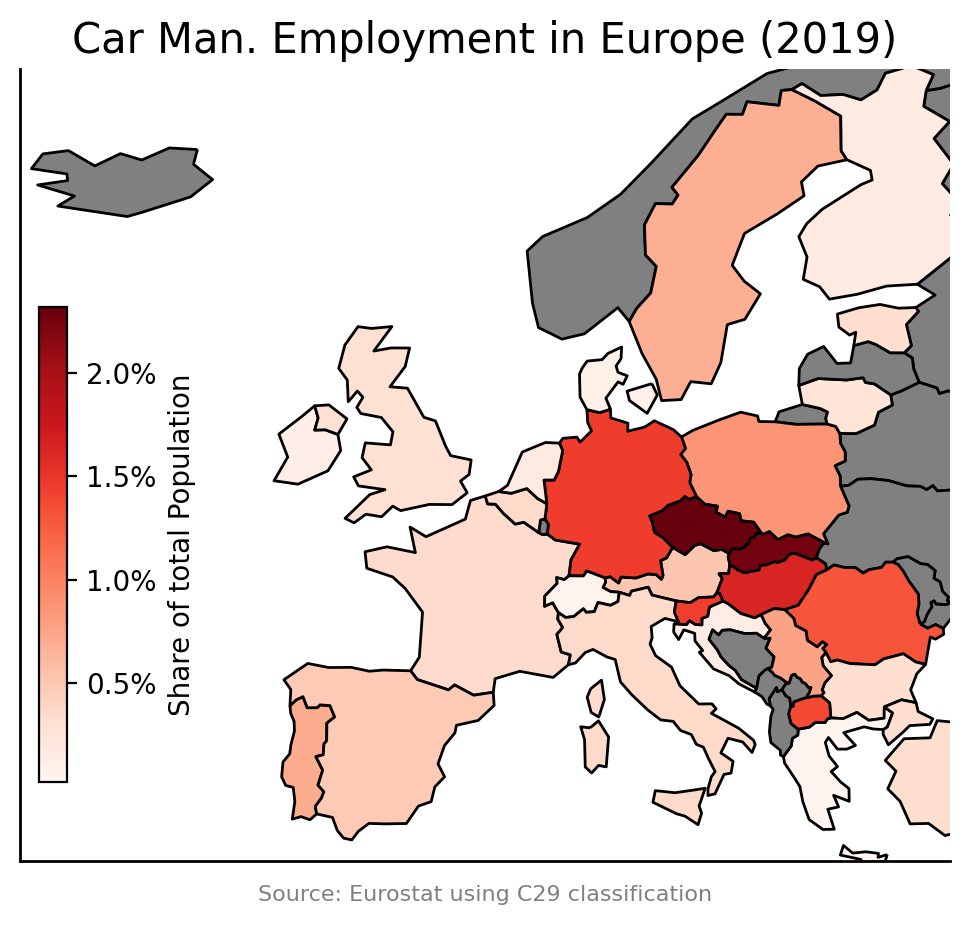

In [19]:
# Create gradiant
cmap = plt.get_cmap('Reds')  # Use the 'Reds' colormap
norm = Normalize(vmin=merged_gdf['employment_rate'].min(), vmax=merged_gdf['employment_rate'].max())  # Normalize to data range
merged_gdf['color_emp'] = merged_gdf['employment_rate'].apply(lambda x: to_hex(cmap(norm(x))) if not pd.isna(x) else '#808080')  # Save colors in 'color_emp'

# Plot istelf
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)

merged_gdf.plot(ax=ax, color=merged_gdf['color_emp'], edgecolor='black')

ax.set_title('Car Man. Employment in Europe (2019)', fontsize=15)

ax.set_ylim(35, 70)
ax.set_xlim(-25, 30)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array, as the values are already normalized

# Create an inset for the colorbar
cax = ax.inset_axes([0.02, 0.1, 0.03, 0.6])  # [x, y, width, height]
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Share of total Population', fontsize=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}%"))

ax.annotate('Source: Eurostat using C29 classification',
            xy=(0.5, -0.05), ha='center', xycoords='axes fraction', fontsize=8, color='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

plt.show()

employment_plot = fig


# EV Vote

In [20]:
# Manual creation of df
data = {
    "country": [
        "Italy", "France", "Poland", "Netherlands", "Ireland", "Latvia", 
        "Lithuania", "Estonia", "Bulgaria", "Denmark", 
        "Germany", "Hungary", "Malta", "Slovenia", "Slovakia",
        "Belgium", "Croatia", "Czechia", "Greece", "Spain", 
        "Cyprus", "Luxembourg", "Austria", "Portugal", "Romania", 
        "Sweden", "Finland"
    ],
    "Vote": [
        "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", 
        "Yes", "Yes", "Yes", "Yes", 
        "No", "No", "No", "No", "No",
        "Abstain", "Abstain", "Abstain", "Abstain", "Abstain", 
        "Abstain", "Abstain", "Abstain", "Abstain", "Abstain", 
        "Abstain", "Abstain"
    ]
}

df = pd.DataFrame(data)

#print(df)


In [21]:
# Merge the dataframes on the 'country' column
merged_gdf_with_vote = merged_gdf.merge(df, left_index=True, right_on='country', how='left')

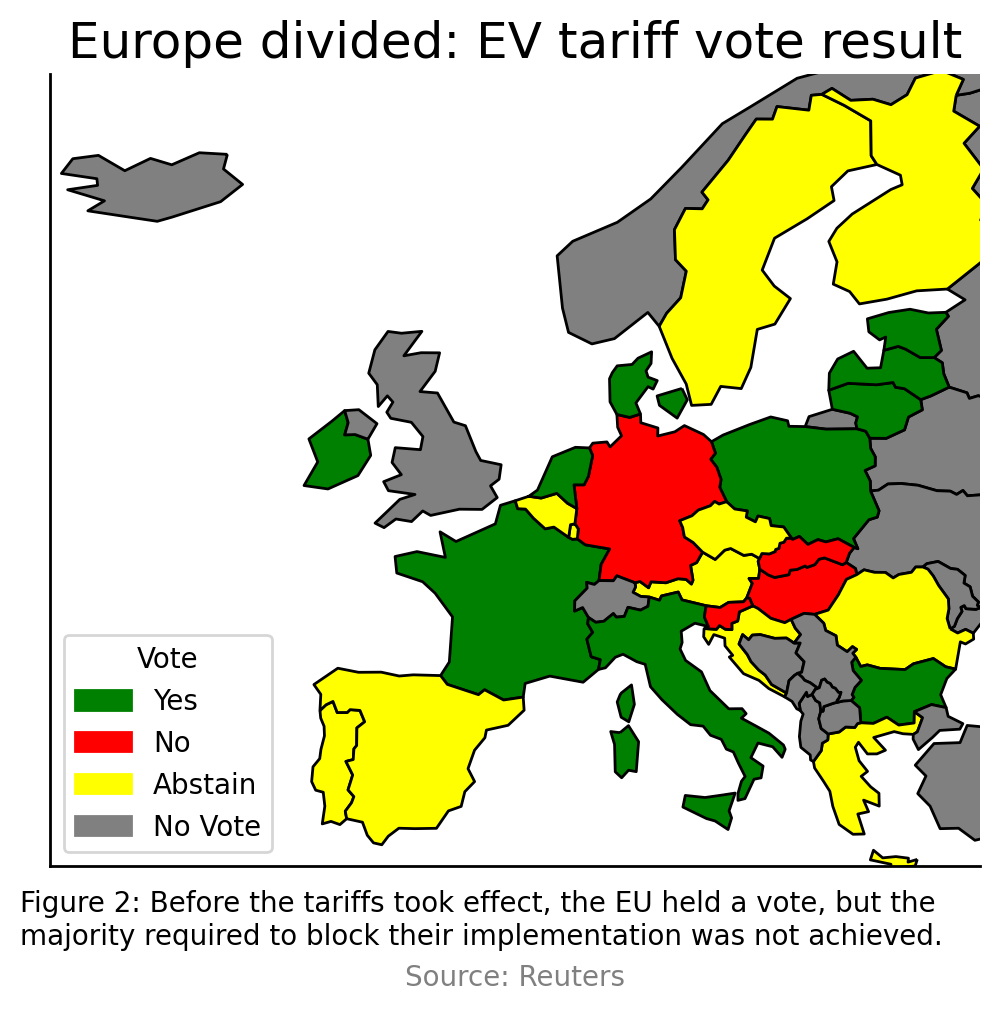

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)

# colors for the votes
vote_colors = {'Yes': 'green', 'No': 'red', 'Abstain': 'yellow', 'No Vote': 'gray'}

merged_gdf_with_vote['Vote'] = merged_gdf_with_vote['Vote'].fillna('No Vote')

#Plot itself
merged_gdf_with_vote.plot(ax=ax, color=merged_gdf_with_vote['Vote'].map(vote_colors), edgecolor='black')

ax.set_title('Europe divided: EV tariff vote result', fontsize=18)

fig.text(0.1, 0.1, 'Figure 2: Before the tariffs took effect, the EU held a vote, but the\nmajority required to block their implementation was not achieved.', ha='left', fontsize=10, color='black')

ax.annotate('Source: Reuters', xy=(0.5, -0.15), ha='center', xycoords='axes fraction', fontsize=10, color='gray')

legend_patches = [mpatches.Patch(color=color, label=vote) for vote, color in vote_colors.items()]
ax.legend(handles=legend_patches, title='Vote', loc='lower left')

ax.set_ylim(35, 70)
ax.set_xlim(-25, 30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

plt.show()

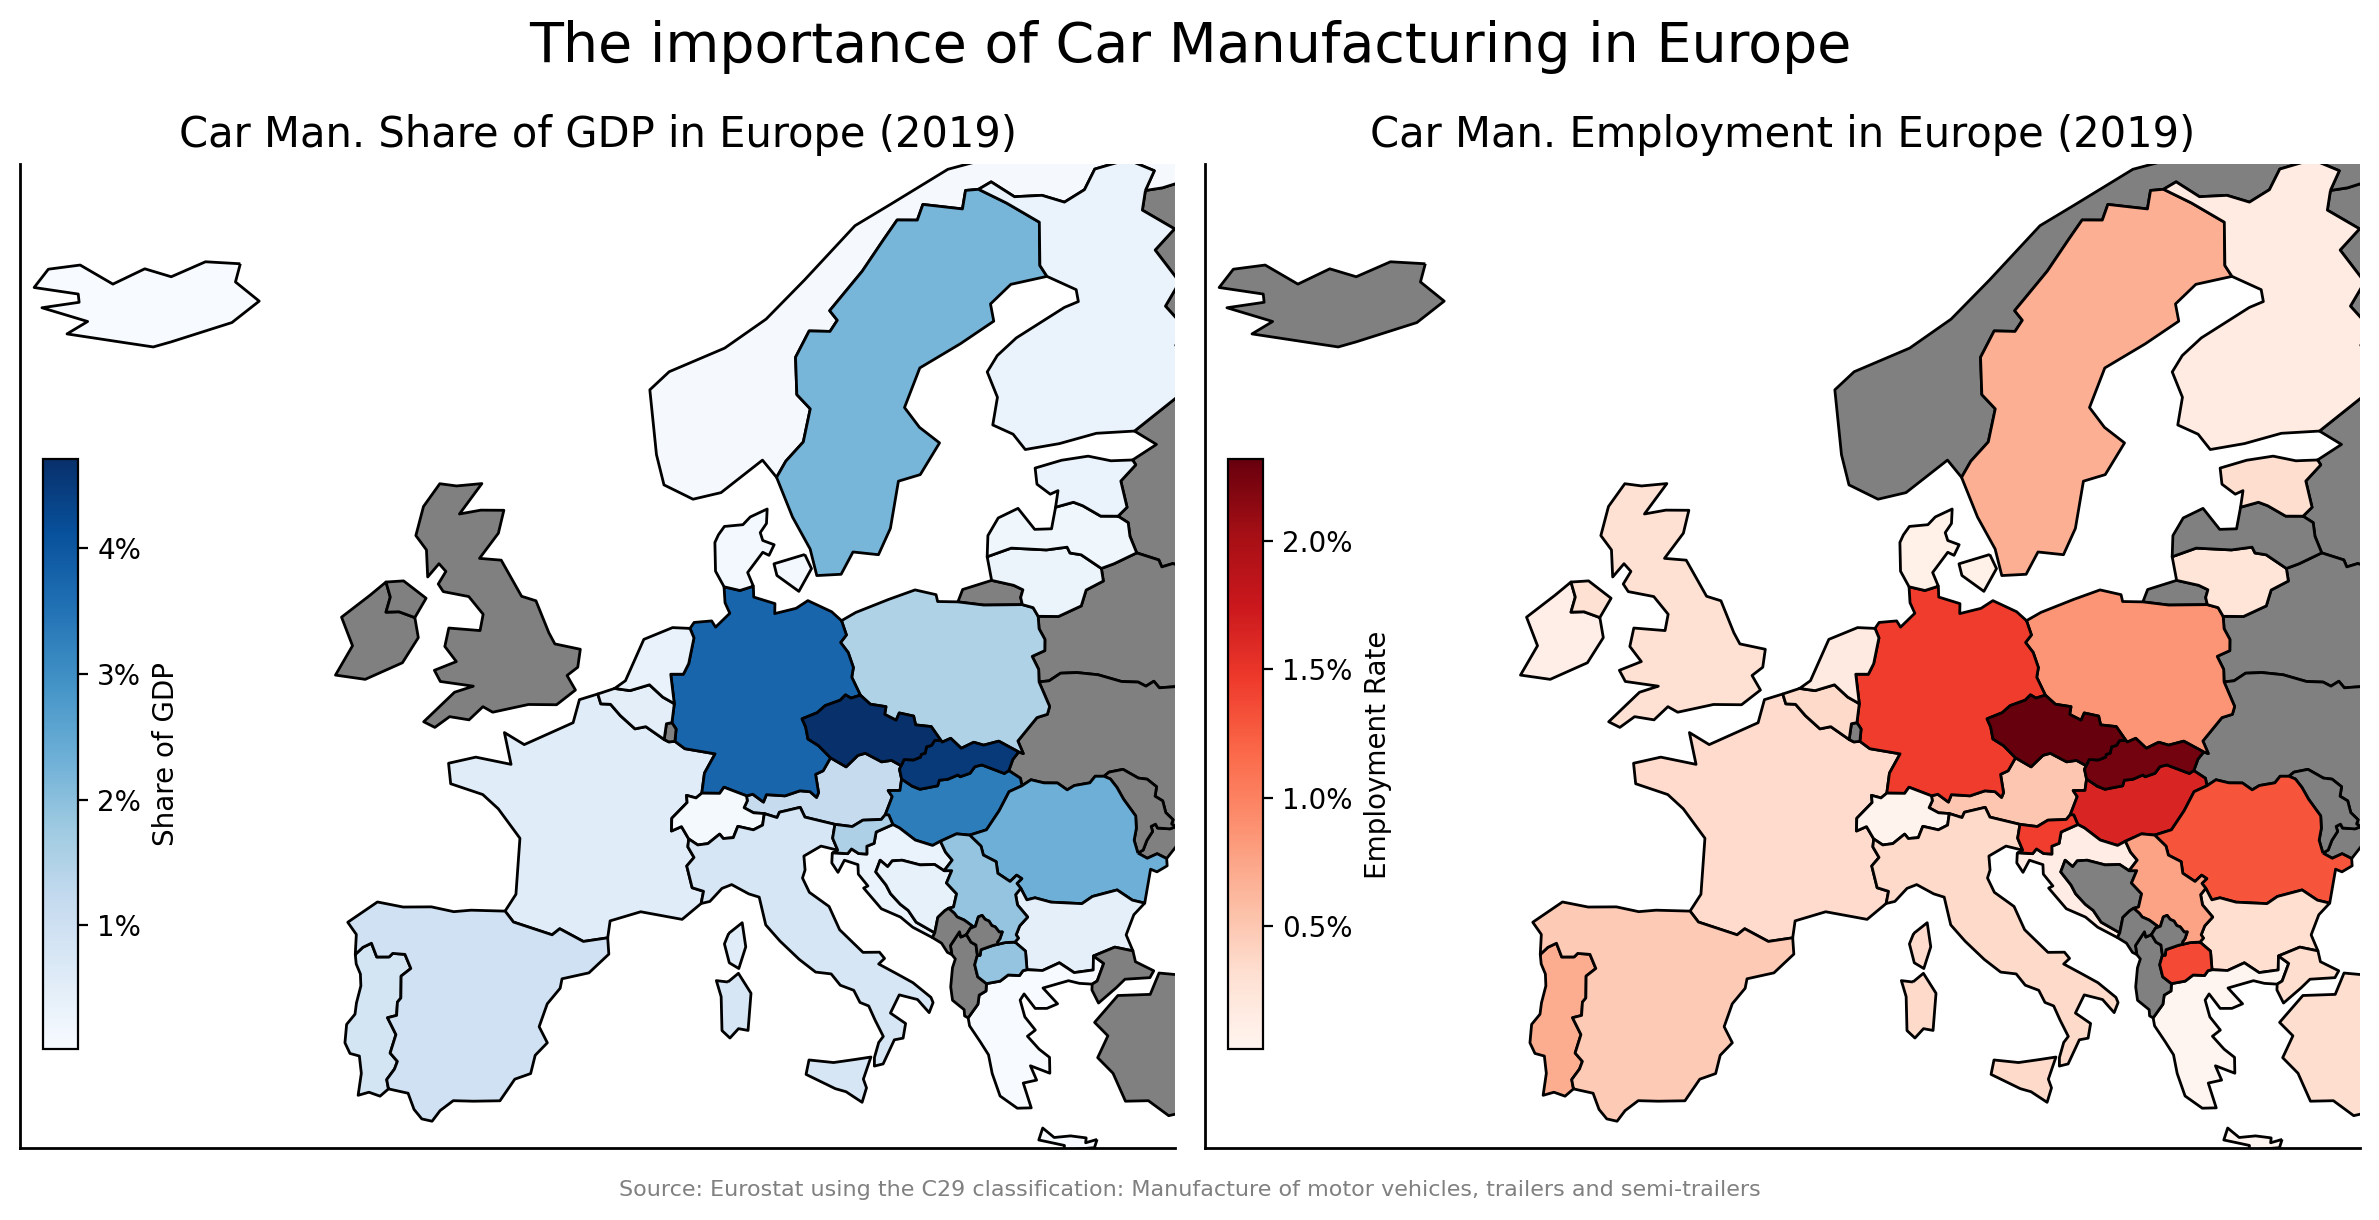

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# manufacturing share of GDP map
merged_gdf.plot(ax=ax1, color=merged_gdf['color_gdp'], edgecolor='black')
ax1.set_title('Car Man. Share of GDP in Europe (2019)', fontsize=15)
ax1.set_ylim(35, 70)
ax1.set_xlim(-25, 30)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

# gradient again
cmap = plt.get_cmap('Blues')
norm = Normalize(vmin=merged_gdf['man_share_GDP_2019'].min(), vmax=merged_gdf['man_share_GDP_2019'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array, as the values are already normalized

cax = ax1.inset_axes([0.02, 0.1, 0.03, 0.6])  # [x, y, width, height] as a fraction of the main plot area
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Share of GDP', fontsize=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

# employment rate map
merged_gdf.plot(ax=ax2, color=merged_gdf['color_emp'], edgecolor='black')
ax2.set_title('Car Man. Employment in Europe (2019)', fontsize=15)
ax2.set_ylim(35, 70)
ax2.set_xlim(-25, 30)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['left'].set_linewidth(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

cmap_emp = plt.get_cmap('Reds')
norm_emp = Normalize(vmin=merged_gdf['employment_rate'].min(), vmax=merged_gdf['employment_rate'].max())
sm_emp = ScalarMappable(cmap=cmap_emp, norm=norm_emp)
sm_emp.set_array([])  # empty array, as the values are already normalized

cax_emp = ax2.inset_axes([0.02, 0.1, 0.03, 0.6])  # [x, y, width, height]
cbar_emp = fig.colorbar(sm_emp, cax=cax_emp, orientation='vertical')
cbar_emp.set_label('Employment Rate', fontsize=10)
cbar_emp.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}%"))

fig.tight_layout()
fig.suptitle('The importance of Car Manufacturing in Europe', fontsize=20, y=1.03)

fig.text(0.5, 0.05, 'Source: Eurostat using the C29 classification: Manufacture of motor vehicles, trailers and semi-trailers', 
         ha='center', fontsize=8, color='gray')

plt.show()